In [20]:
from elasticsearch import Elasticsearch
import os 
import glob
import regex
import matplotlib.pyplot as plt
import spacy
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import math

In [6]:
es = Elasticsearch('http://localhost:9200')
es.info()

{'name': 'DESKTOP-V2HVSQ4',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'j0wajJxETBCrSGJPdFO_4g',
 'version': {'number': '7.10.1',
  'build_flavor': 'default',
  'build_type': 'zip',
  'build_hash': '1c34507e66d7db1211f66f3513706fdf548736aa',
  'build_date': '2020-12-05T01:00:33.671820Z',
  'build_snapshot': False,
  'lucene_version': '8.7.0',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

# 1. Use SpaCy tokenizer API to tokenize the text from the law corpus.

In [2]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish
nlp = Polish()
tokenizer = Tokenizer(nlp.vocab)
spacy.__version__, tokenizer

('3.1.4', <spacy.tokenizer.Tokenizer at 0x232377684c0>)

In [3]:
# Test
tokens = tokenizer("This is a sentence")
print(len(tokens) == 4)
print(tokens)

True
This is a sentence


In [4]:
files = [f for f in glob.glob('../ustawy/*')]
len(files)

1179

In [70]:
files_content = []
for file in glob.glob('../ustawy/*'):
    fname = os.path.basename(file)
    with open(file, encoding='UTF-8') as f:
        text = f.read()
        files_content.append(text.lower())

# Zapytać o to, bo nlp() i tokenizer() dają różne wyniki, przez to tokenizer wygląda na lepsze IMO, ale prowadzący uzywał na wykładzie nlp() i nlp() daje takie które zgadzają sie z wymaganiami...

In [71]:
texts = files_content
full_count = Counter()
single_words = Counter()
for i, t in enumerate(texts):
    # tokens = tokenizer(t)
    tokens = nlp(t)
    for token in tokens:
        single_words[token.orth_] += 1 # Equivalently, token.text
    bigram = zip(tokens[:-1],tokens[1:])
    for e in list(bigram):
        r1 = ' '.join([str(elem) for elem in e])
        # r2 = str(e[0]) + " " + str(e[1])
        full_count[r1] += 1


# Zapytać czy liszbę słów pojedyńczo zliczać można tak jak tu osobno, czy policzyć to co jest w  wynikowym full_count lepiej?

In [72]:
full_count

Counter({'\n\n\n\n dz.u': 836,
         'dz.u .': 5752,
         '. z': 5012,
         'z 1993': 511,
         '1993 r': 774,
         'r .': 33010,
         '. nr': 20313,
         'nr 129': 120,
         '129 ,': 150,
         ', poz': 39655,
         'poz .': 45198,
         '. 599': 38,
         '599 \n                                ': 1,
         '\n                                 ustawa': 58,
         'ustawa \n                        ': 79,
         '\n                         z': 81,
         'z dnia': 8989,
         'dnia 9': 210,
         '9 grudnia': 6,
         'grudnia 1993': 99,
         '. \n                                    \n             ': 12,
         '\n                                    \n              o': 12,
         'o zmianie': 1176,
         'zmianie ustawy': 829,
         'ustawy o': 1394,
         'o podatku': 496,
         'podatku od': 362,
         'od towarów': 249,
         'towarów i': 504,
         'i usług': 528,
         'usług \n              

In [73]:
single_words

Counter({'\n\n\n\n': 842,
         'dz.u': 5767,
         '.': 431293,
         'z': 82438,
         '1993': 804,
         'r': 33172,
         'nr': 44942,
         '129': 268,
         ',': 341126,
         'poz': 45224,
         '599': 40,
         '\n                                ': 1630,
         'ustawa': 3235,
         '\n                        ': 231,
         'dnia': 17954,
         '9': 5118,
         'grudnia': 2117,
         '\n                                    \n             ': 12,
         'o': 64776,
         'zmianie': 1518,
         'ustawy': 13099,
         'podatku': 2048,
         'od': 16683,
         'towarów': 1920,
         'i': 90006,
         'usług': 1629,
         'oraz': 33558,
         'akcyzowym': 90,
         '\n                                    \n                                    \n                                ': 151,
         'art': 83804,
         '1': 72952,
         '\n': 181703,
         'w': 201200,
         'ustawie': 5478,
         '

# 3. Discard bigrams containing characters other than letters. Make sure that you discard the invalid entries after computing the bigram counts.

In [74]:
# wyczysc bigramy
for word in list(full_count):
    found = regex.findall(r'(?:(?:\n|\t|\r)|[^\p{L}\s]|\s{2,})', word, flags=regex.IGNORECASE)
    if found:
        del full_count[word]   

In [75]:
# wyczysc słowa
for word in list(single_words):
    found = regex.findall(r'(?:(?:\n|\t|\r)|[^\p{L}])', word, flags=regex.IGNORECASE)
    if found:
        del single_words[word]   

In [76]:
full_count

Counter({'z dnia': 8989,
         'o zmianie': 1176,
         'zmianie ustawy': 829,
         'ustawy o': 1394,
         'o podatku': 496,
         'podatku od': 362,
         'od towarów': 249,
         'towarów i': 504,
         'i usług': 528,
         'oraz o': 905,
         'podatku akcyzowym': 52,
         'w ustawie': 4777,
         'ustawie z': 3624,
         'usług oraz': 119,
         'i nr': 7871,
         'wprowadza się': 1742,
         'się następujące': 1636,
         'w art': 30170,
         'dotychczasowa treść': 37,
         'treść otrzymuje': 37,
         'otrzymuje oznaczenie': 40,
         'oznaczenie ust': 61,
         'dodaje się': 7960,
         'się ust': 3405,
         'w brzmieniu': 6690,
         'rada ministrów': 852,
         'ministrów może': 143,
         'może określać': 49,
         'w drodze': 6623,
         'drodze rozporządzenia': 3671,
         'towary i': 19,
         'i usługi': 26,
         'z wyjątkiem': 1444,
         'wyjątkiem wyrobów': 19,
 

In [77]:
# full_count
len(full_count)

481417

In [78]:
single_words

Counter({'z': 82438,
         'r': 33172,
         'nr': 44942,
         'poz': 45224,
         'ustawa': 3235,
         'dnia': 17954,
         'grudnia': 2117,
         'o': 64776,
         'zmianie': 1518,
         'ustawy': 13099,
         'podatku': 2048,
         'od': 16683,
         'towarów': 1920,
         'i': 90006,
         'usług': 1629,
         'oraz': 33558,
         'akcyzowym': 90,
         'art': 83804,
         'w': 201200,
         'ustawie': 5478,
         'stycznia': 1894,
         'wprowadza': 1999,
         'się': 45886,
         'następujące': 2276,
         'zmiany': 4016,
         'a': 16969,
         'dotychczasowa': 50,
         'treść': 486,
         'otrzymuje': 9835,
         'oznaczenie': 556,
         'ust': 53636,
         'b': 6840,
         'dodaje': 8423,
         'brzmieniu': 7295,
         'rada': 1997,
         'ministrów': 2425,
         'może': 12096,
         'określać': 357,
         'drodze': 7179,
         'rozporządzenia': 5338,
       

# 4. Use pointwise mutual information to compute the measure for all pairs of words.

In [35]:
def pmi(word1, word2, unigram_freq, bigram_freq):
    prob_word1 = unigram_freq[word1] / float(sum(unigram_freq.values()))
    prob_word2 = unigram_freq[word2] / float(sum(unigram_freq.values()))
    prob_word1_word2 = bigram_freq[" ".join([word1, word2])] / float(sum(bigram_freq.values()))
    return math.log(prob_word1_word2/float(prob_word1*prob_word2),2) 

In [79]:
full_count["zobowiązuje się"], single_words["zobowiązuje"], single_words["się"], pmi("zobowiązuje", "się", single_words, full_count)

(32, 75, 45886, 5.580878386952086)

In [80]:
pmi_score = {}
for pair, count in full_count.items():
    w = pair.split(" ")
    pmi_score[pair] = pmi(w[0], w[1], single_words, full_count)
# full_count["zobowiązuje się"]

KeyboardInterrupt: 

In [81]:
len(pmi_score)

288

In [83]:
all_single_count = float(sum(single_words.values()))
all_bigram_count = float(sum(full_count.values()))

pmi_score = {}

for pair, count in full_count.items():
    w = pair.split(" ")
    pmi_score[pair] = math.log((count/all_bigram_count)/float((single_words[w[0]]/all_single_count)*(single_words[w[1]]/all_single_count)),2) 

# Zaputać o to, bo mi tu wychodzi PMI 22, a ludzie mówią że najwięcej to 15.45 mieli

# 5. Sort the word pairs according to that measure in the descending order and determine top 10 entries.

In [84]:
# pmi_score
sorted(pmi_score.items(), key=lambda item: (-item[1], item[0]))


[('aegroti suprema', 22.2954635058116),
 ('aerodynamicznej szorstkości', 22.2954635058116),
 ('aethina tumida', 22.2954635058116),
 ('agenci ubezpieczeniowi', 22.2954635058116),
 ('agregatach pralniczych', 22.2954635058116),
 ('agricoltura biologica', 22.2954635058116),
 ('agriculture biologique', 22.2954635058116),
 ('agrotechniki nienaruszającej', 22.2954635058116),
 ('akapicie preambuły', 22.2954635058116),
 ('aktowi normatywnemu', 22.2954635058116),
 ('aldehydu furfurylowego', 22.2954635058116),
 ('aleksander małachowski', 22.2954635058116),
 ('aleksandrów kujawski', 22.2954635058116),
 ('algorytmem szyfrowym', 22.2954635058116),
 ('ankieterzy statystyczni', 22.2954635058116),
 ('antykonkurencyjnym koncentracjom', 22.2954635058116),
 ('aparatami rentgenowskimi', 22.2954635058116),
 ('archidiecezji warmińskiej', 22.2954635058116),
 ('aresztami śledczymi', 22.2954635058116),
 ('aromatyzowanego koktajlu', 22.2954635058116),
 ('atrakcyjnego turystycznie', 22.2954635058116),
 ('aureus w

# 6. Filter bigrams with number of occurrences lower than 5. Determine top 10 entries for the remaining dataset (>=5 occurrences).

In [85]:
all_single_count = float(sum(single_words.values()))
all_bigram_count = float(sum(full_count.values()))

pmi_score_but_5 = {}

for pair, count in full_count.items():
    if count < 5:
        continue
    w = pair.split(" ")
    pmi_score_but_5[pair] = math.log((count/all_bigram_count)/float((single_words[w[0]]/all_single_count)*(single_words[w[1]]/all_single_count)),2) 

In [86]:
sorted(pmi_score_but_5.items(), key=lambda item: (-item[1], item[0]))

[('grzegorz schetyna', 19.97353541092424),
 ('klęskami żywiołowymi', 19.97353541092424),
 ('młynki młotkowe', 19.97353541092424),
 ('młyny kulowe', 19.97353541092424),
 ('obcowania płciowego', 19.97353541092424),
 ('otworami wiertniczymi', 19.97353541092424),
 ('ręcznego miotacza', 19.97353541092424),
 ('stajnią wyścigową', 19.97353541092424),
 ('zaszkodzić wynikom', 19.97353541092424),
 ('środa wlkp', 19.97353541092424),
 ('świeckie przygotowujące', 19.97353541092424),
 ('adama mickiewicza', 19.710501005090446),
 ('diagności laboratoryjni', 19.710501005090446),
 ('mleczka makowego', 19.710501005090446),
 ('odczynów poszczepiennych', 19.710501005090446),
 ('przeponowe rurowe', 19.710501005090446),
 ('chwytów obezwładniających', 19.488108583753995),
 ('klęską żywiołową', 19.488108583753995),
 ('lambrekiny okienne', 19.488108583753995),
 ('papierem wartościowym', 19.488108583753995),
 ('piotrków trybunalski', 19.488108583753995),
 ('schedę spadkową', 19.488108583753995),
 ('słomę makową'

# 7. Use log likelihood ratio (LLR) to compute the measure for all pairs of words.

# zapytać bo nie wiem czemu wychodzi mi ujemnie :/

In [127]:
# def H(counts: List[int]) -> float:
def H(counts) -> float:
    try:
        total = float(sum(counts))
        # print(total)
        # Note tricky way to avoid 0*log(0)
        return -sum([k/total * math.log(k/total + (k==0)) for k in counts])
        # return -sum([k * math.log(k / total + (k==0)) for k in counts])

    except ValueError:
        print(counts)
        total = float(sum(counts))
        print(total)
        for k in counts:
            print()
            print(k/total)
            print(k/total + (k==0))
            print()


def llr(a: int, b: int, ab_count: int, total_tokens: int) -> float:
    k11 = float(ab_count) # count of bigrams (a,b)
    # k12 = token_counts[b] - ab_count
    k12 = float(b - ab_count)
    # k21 = token_counts[a] - ab_count
    k21 = float(a - ab_count)
    k22 = float(total_tokens - k12 - k21 - k11)
    
    return 2 * (H([k11 + k12, k21 + k22]) +
                H([k11 + k21, k12 + k22]) -
                H([k11, k12, k21, k22]))

In [114]:
# test
# ilosc_slowa_1, ilosc_slowa_2, ilosc_wszystkich_bigramow, ilosc_wszystkich_slow
llr(single_words["zobowiązuje"], single_words["się"], full_count["zobowiązuje się"], all_single_count)
# llr(single_words["zobowiązuje"], single_words["się"], all_bigram_count, all_single_count)

3566806.0
3566806.0
3566806.0


-4.973382695128148e-05

In [128]:
llr_score = {}

for pair, count in full_count.items():
    w = pair.split(" ")
    llr_score[pair] = llr(single_words[w[0]], single_words[w[1]], count, all_single_count)

In [130]:
sorted(llr_score.items(), key=lambda item: (-item[1], item[0]))
# sorted(llr_score.items(), key = lambda x: x[1], reverse=True)
# llr_score

[('mowa w', 0.04298440238453016),
 ('otrzymuje brzmienie', 0.03209824810335744),
 ('których mowa', 0.03109251163663146),
 ('o których', 0.02298087824060685),
 ('w art', 0.020701446675299717),
 ('którym mowa', 0.02050059050073888),
 ('dodaje się', 0.018834268231912282),
 ('w ust', 0.01703877063429804),
 ('do spraw', 0.016447220027491244),
 ('o którym', 0.015614192554698203),
 ('stosuje się', 0.014539471085039724),
 ('minister właściwy', 0.013048575270616425),
 ('na podstawie', 0.012755838727928848),
 ('z dnia', 0.012394882542923369),
 ('której mowa', 0.01173771346124311),
 ('drodze rozporządzenia', 0.011570405857413868),
 ('rzeczypospolitej polskiej', 0.010736856816315584),
 ('zastępuje się', 0.010392570848806765),
 ('w brzmieniu', 0.009694568171703888),
 ('w drodze', 0.009656293423179363),
 ('od dnia', 0.009500989373692328),
 ('właściwy do', 0.009232199294724297),
 ('o której', 0.00887285794394399),
 ('a także', 0.008438349589314526),
 ('co najmniej', 0.007856900564419546),
 ('w przypa

# 1. Make sure the texts in the corpus does not contain HTML code.

In [4]:
es.indices.create(index='test-index2')

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'test-index2'}

In [6]:
files = [f for f in glob.glob('../ustawy/*')]
len(files)

1179

In [7]:
files_content = []
for file in glob.glob('../ustawy/*'):
    fname = os.path.basename(file)
    with open(file, encoding='UTF-8') as f:
        text = f.read()
        files_content.append(text)

In [8]:
regexp_html = r'<[a-z]*>'

for file in files:
    with open(file, encoding='UTF-8') as f:
        text = f.read()
        reg_html = regex.findall(regexp_html, text, flags=regex.IGNORECASE) 
        if reg_html:
            print(reg_html)
            

# 2. Use SpaCy tokenizer API to tokenize the text from the cleaned law corpus.

In [13]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish
nlp = Polish()
tokenizer = Tokenizer(nlp.vocab)
spacy.__version__

'3.1.4'

In [14]:
tokenizer

In [15]:
# Test
tokens = tokenizer("This is a sentence")
print(len(tokens) == 4)
print(tokens)

True
This is a sentence


In [17]:
# Test
texts = ["ala ma kota", "ustawa ustawie nie jest równa nigdy, ale ustawa ustawę zje"]
tokenized = []
for doc in tokenizer.pipe(texts, batch_size=1):
    tokenized.append(doc)
    pass
tokenized

[ala ma kota, ustawa ustawie nie jest równa nigdy, ale ustawa ustawę zje]

In [1]:
texts = files_content
for i, t in enumerate(texts):
    tokens = tokenizer(t)
    print(tokens)

NameError: name 'files_content' is not defined

In [19]:
tokenizer.explain(files_content[0][:50])

[('TOKEN', 'Dz.U.'),
 ('TOKEN', 'z'),
 ('TOKEN', '1993'),
 ('TOKEN', 'r.'),
 ('TOKEN', 'Nr'),
 ('TOKEN', '129,'),
 ('TOKEN', 'poz.'),
 ('TOKEN', '599')]

# 3. Compute frequency list for each of the processed files.

In [20]:
def word_count(string):
    my_string = nlp(string)
    counts = Counter()
    for token in my_string:
        counts[token.orth_] += 1 # Equivalently, token.text
    return counts

In [23]:
# 3. frequesncy list dla kazdego dokumentu
freq_list_separate = []
for doc in files_content:
    freq_list_separate.append(word_count(doc))

In [25]:
freq_list_separate[:1]

[Counter({'\n\n\n\n': 1,
          'Dz': 4,
          '.': 497,
          'U': 4,
          'z': 106,
          '1993': 9,
          'r': 20,
          'Nr': 11,
          '129': 2,
          ',': 306,
          'poz': 17,
          '599': 2,
          '\n                                ': 3,
          'USTAWA': 1,
          '\n                        ': 2,
          'dnia': 12,
          '9': 9,
          'grudnia': 9,
          '\n                                    \n             ': 1,
          'o': 41,
          'zmianie': 1,
          'ustawy': 10,
          'podatku': 42,
          'od': 28,
          'towarów': 49,
          'i': 150,
          'usług': 29,
          'oraz': 30,
          'akcyzowym': 4,
          '\n                                    \n                                    \n                                ': 1,
          'Art': 8,
          '1': 94,
          '\n': 561,
          'W': 12,
          'ustawie': 1,
          '8': 10,
          'stycznia': 2,
    

# 4. Aggregate the result to obtain one global frequency list.

In [26]:
# 4. frequency list dla wsyzstkich dokumentów
full_count = Counter()
for counter in freq_list_separate:
    full_count += counter

In [28]:
full_count

Counter({'\n\n\n\n': 842,
         'Dz': 8884,
         '.': 437694,
         'U': 8320,
         'z': 81531,
         '1993': 804,
         'r': 33052,
         'Nr': 43418,
         '129': 268,
         ',': 341126,
         'poz': 45203,
         '599': 40,
         '\n                                ': 1630,
         'USTAWA': 999,
         '\n                        ': 231,
         'dnia': 17937,
         '9': 5118,
         'grudnia': 2117,
         '\n                                    \n             ': 12,
         'o': 64169,
         'zmianie': 1518,
         'ustawy': 13067,
         'podatku': 2046,
         'od': 16032,
         'towarów': 1916,
         'i': 89314,
         'usług': 1609,
         'oraz': 33552,
         'akcyzowym': 90,
         '\n                                    \n                                    \n                                ': 151,
         'Art': 30838,
         '1': 73108,
         '\n': 181703,
         'W': 13715,
         'ustawie': 

# 5. Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).

In [29]:
# 5. odrzuc wszystkie ponizej 2 znakow i ktore zaweiraja znaki nieliterowe
for word in list(full_count):
    found = regex.findall(r'(?:(?:\n|\t|\r)|[^\p{L}])', word, flags=regex.IGNORECASE)
    if len(word) < 2 or found:
        del full_count[word]   

In [30]:
full_count

Counter({'Dz': 8884,
         'Nr': 43418,
         'poz': 45203,
         'USTAWA': 999,
         'dnia': 17937,
         'grudnia': 2117,
         'zmianie': 1518,
         'ustawy': 13067,
         'podatku': 2046,
         'od': 16032,
         'towarów': 1916,
         'usług': 1609,
         'oraz': 33552,
         'akcyzowym': 90,
         'Art': 30838,
         'ustawie': 5473,
         'stycznia': 1894,
         'wprowadza': 1988,
         'się': 45882,
         'następujące': 2276,
         'zmiany': 2830,
         'art': 52961,
         'dotychczasowa': 48,
         'treść': 473,
         'otrzymuje': 9835,
         'oznaczenie': 533,
         'ust': 53631,
         'dodaje': 8423,
         'brzmieniu': 7295,
         'Rada': 1598,
         'Ministrów': 2300,
         'może': 12076,
         'określać': 357,
         'drodze': 7179,
         'rozporządzenia': 5313,
         'towary': 520,
         'usługi': 888,
         'wyjątkiem': 1670,
         'wyrobów': 1357,
         

# 6. Make a plot in a logarithmic scale (for X and Y): 
- X-axis should contain the rank of a term, meaning the first rank belongs to the term with the highest number of occurrences; the terms with the same number of occurrences should be ordered by their name,
- Y-axis should contain the number of occurrences of the term with given rank.

In [31]:
full_count_sorted = np.array(sorted(full_count.items(), key=lambda item: (-item[1], item[0])))[:62328]
print(full_count_sorted.shape)
full_count_sorted[:30]

(62328, 2)


array([['do', '57269'],
       ['ust', '53631'],
       ['art', '52961'],
       ['na', '49421'],
       ['się', '45882'],
       ['lub', '45800'],
       ['poz', '45203'],
       ['Nr', '43418'],
       ['oraz', '33552'],
       ['Art', '30838'],
       ['mowa', '28780'],
       ['nie', '22345'],
       ['przez', '20731'],
       ['pkt', '19124'],
       ['dnia', '17937'],
       ['których', '17928'],
       ['od', '16032'],
       ['jest', '13193'],
       ['ustawy', '13067'],
       ['po', '12991'],
       ['może', '12076'],
       ['którym', '11787'],
       ['brzmienie', '10576'],
       ['za', '10328'],
       ['otrzymuje', '9835'],
       ['spraw', '9034'],
       ['Dz', '8884'],
       ['albo', '8708'],
       ['dodaje', '8423'],
       ['ich', '8196']], dtype='<U65')

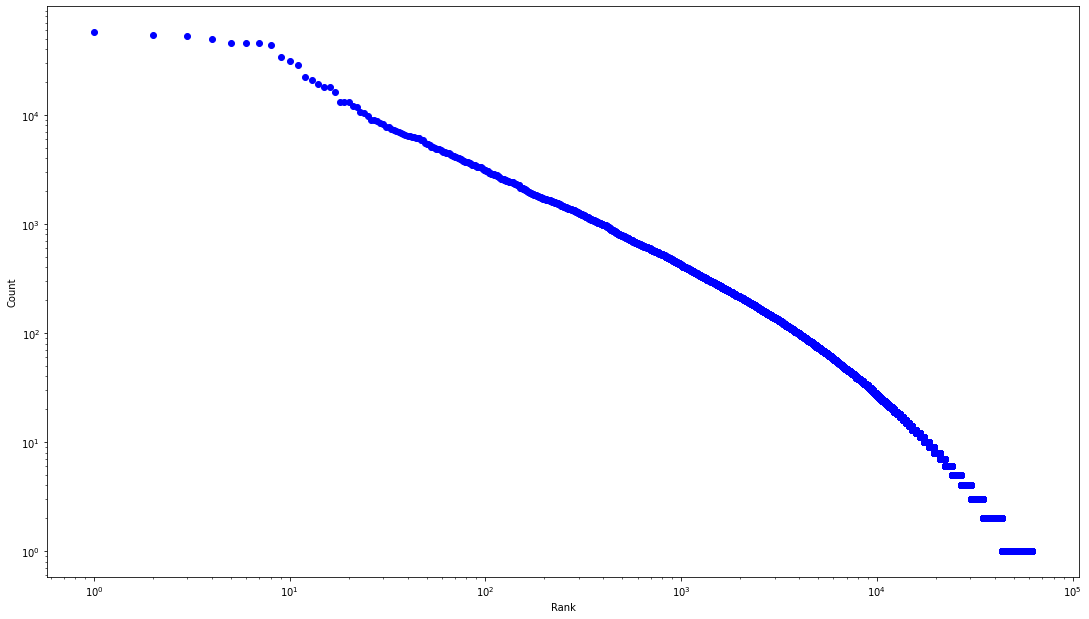

In [33]:
# 6. wykres logarytmiczny.
'''
    1. posortuj alfabetycznie
    2. posortuj po wystąpieniach
    3. Oś X ma mieć rank czyli iść po kolei od najczęstszego słowa do najrzadszego
    4. OŚ Y ma mieć ilość wytąpień.
'''

x = range(1,full_count_sorted.shape[0]+1)
y = full_count_sorted[:,1].astype('int')

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.scatter(x, y, color='b')

ax.set(xlabel='Rank', ylabel='Count')
ax.set_yscale('log')
ax.set_xscale('log')

fig.savefig("test.png")
plt.show()

# 7. Install Morfeusz (Binding dla Pythona) and use it to find all words that do not appear in that dictionary.

In [34]:
from morfeusz2 import *

morf = Morfeusz()
analysis_result = morf.analyse("ala, xd")
analysis_result, analysis_result[0][2][2]

([(0, 1, ('ala', 'Ala', 'subst:sg:nom:f', ['imię'], [])),
  (0, 1, ('ala', 'Al', 'subst:sg:gen.acc:m1', ['imię'], [])),
  (0, 1, ('ala', 'Alo', 'subst:sg:gen.acc:m1', ['imię'], [])),
  (1, 2, (',', ',', 'interp', [], [])),
  (2, 3, ('xd', 'xd', 'ign', [], []))],
 'subst:sg:nom:f')

In [36]:
counted_words = full_count_sorted[:,0]
not_in_morfeusz = []
for word in counted_words:
    morf_result = morf.analyse(word)
    if morf_result[0][2][2] == "ign":
        not_in_morfeusz.append(word)

not_in_morfeusz

['poz',
 'późn',
 'str',
 'GMO',
 'SWW',
 'operacyjno',
 'SKW',
 'zm',
 'ex',
 'IKE',
 'rolno',
 'techniczno',
 'remediacji',
 'rozdz',
 'URE',
 'UKE',
 'itp',
 'kN',
 'charytatywno',
 'sanitarno',
 'CN',
 'PKWiU',
 'UDT',
 'społeczno',
 'np',
 'BSWSG',
 'BSWP',
 'Społeczno',
 'Biobójczych',
 'organizacyjno',
 'PHS',
 'komandytowo',
 'wodociągowo',
 'HCFC',
 'architektoniczno',
 'FEP',
 'adopcyjno',
 'MgO',
 'dyplomatyczno',
 'UTK',
 'emerytalno',
 'FRD',
 'RON',
 'UOKiK',
 'CBŚP',
 'DOKE',
 'Rolno',
 'HACCP',
 'PCN',
 'vitro',
 'ITS',
 'kontrolno',
 'metylo',
 'inulinowego',
 'EFRROW',
 'fenylo',
 'diagnostyczno',
 'PCB',
 'PLK',
 'ureaformu',
 'biuretu',
 'Cu',
 'TDT',
 'szkolno',
 'ych',
 'ekonomiczno',
 'Poz',
 'disease',
 'psychologiczno',
 'tj',
 'pomiarowo',
 'Bankowania',
 'IIa',
 'IVa',
 'administracyjno',
 'hydrologiczno',
 'rozpuszc',
 'wymienion',
 'IIIa',
 'difenylo',
 'kulturalno',
 'metylomorfinan',
 'prefinansowanie',
 'Ww',
 'hydroksy',
 'ie',
 'Zn',
 'ureaform',
 'zal

# 8. Find 30 words with the highest ranks that do not belong to the dictionary.

In [37]:
# 8. 30 słów które nie są w morfeuszu
highest_not_in_morfeusz = OrderedDict()
for word, count in full_count_sorted:
    if word in not_in_morfeusz:
        highest_not_in_morfeusz[word] = count

In [38]:
highest_not_in_morfeusz
highest_not_in_morfeusz_but_30 = list(highest_not_in_morfeusz.items())[:30]
list(highest_not_in_morfeusz.items())[:1000], np.array(list(highest_not_in_morfeusz.items())).shape

([('poz', '45203'),
  ('późn', '1065'),
  ('str', '516'),
  ('GMO', '298'),
  ('SWW', '216'),
  ('operacyjno', '209'),
  ('SKW', '196'),
  ('zm', '192'),
  ('ex', '167'),
  ('IKE', '162'),
  ('rolno', '160'),
  ('techniczno', '122'),
  ('remediacji', '120'),
  ('rozdz', '102'),
  ('URE', '101'),
  ('UKE', '97'),
  ('itp', '96'),
  ('kN', '95'),
  ('charytatywno', '87'),
  ('sanitarno', '84'),
  ('CN', '83'),
  ('PKWiU', '81'),
  ('UDT', '77'),
  ('społeczno', '73'),
  ('np', '71'),
  ('BSWSG', '70'),
  ('BSWP', '66'),
  ('Społeczno', '64'),
  ('Biobójczych', '55'),
  ('organizacyjno', '55'),
  ('PHS', '53'),
  ('komandytowo', '51'),
  ('wodociągowo', '47'),
  ('HCFC', '44'),
  ('architektoniczno', '44'),
  ('FEP', '42'),
  ('adopcyjno', '42'),
  ('MgO', '41'),
  ('dyplomatyczno', '41'),
  ('UTK', '40'),
  ('emerytalno', '39'),
  ('FRD', '36'),
  ('RON', '35'),
  ('UOKiK', '35'),
  ('CBŚP', '34'),
  ('DOKE', '34'),
  ('Rolno', '34'),
  ('HACCP', '32'),
  ('PCN', '32'),
  ('vitro', '32')

# 9. Find 30 random words (i.e. shuffle the words) with 5 occurrences that do not belong to the dictionary.

In [39]:
# 9. 30 słów które mają 5 wystąpień i nie są w morfeuszu
highest_not_in_morfeusz_with_5 = OrderedDict()
full_count_sorted_but_shuffled_xd = np.copy(full_count_sorted)
np.random.shuffle(full_count_sorted_but_shuffled_xd)

for word, count in full_count_sorted_but_shuffled_xd:
    if word in not_in_morfeusz and int(count) == 5:
        highest_not_in_morfeusz_with_5[word] = count

In [40]:
len(highest_not_in_morfeusz_with_5)
list(highest_not_in_morfeusz_with_5.items())[:30]
highest_not_in_morfeusz_with_5_but_30 = list(highest_not_in_morfeusz_with_5.items())

In [41]:
highest_not_in_morfeusz_with_5_but_30

[('wodno', '5'),
 ('Agave', '5'),
 ('tów', '5'),
 ('rialnego', '5'),
 ('zawart', '5'),
 ('INCI', '5'),
 ('ppkt', '5'),
 ('vista', '5'),
 ('KPWiG', '5'),
 ('szcze', '5'),
 ('instrumen', '5'),
 ('najmnie', '5'),
 ('organicz', '5'),
 ('RCI', '5'),
 ('geodezyjno', '5'),
 ('ośc', '5'),
 ('Shigella', '5'),
 ('metylofenetyloamina', '5'),
 ('ym', '5'),
 ('informacyjno', '5'),
 ('edukacyjno', '5'),
 ('Contagious', '5'),
 ('nym', '5'),
 ('inspekcyjno', '5'),
 ('ami', '5'),
 ('tzn', '5'),
 ('EudraVigilance', '5'),
 ('JWH', '5'),
 ('Betezda', '5'),
 ('Schetyna', '5'),
 ('próbobiorców', '5'),
 ('regazyfikacyjnego', '5'),
 ('heptanol', '5'),
 ('wapnio', '5'),
 ('GJ', '5'),
 ('mieszkalno', '5'),
 ('sposb', '5'),
 ('winopochodne', '5'),
 ('Wlkp', '5'),
 ('funkcjonalno', '5'),
 ('difenylopropylo', '5'),
 ('jed', '5'),
 ('remediację', '5'),
 ('teryto', '5'),
 ('chelatującym', '5'),
 ('kJ', '5'),
 ('RR', '5'),
 ('denitracyjne', '5'),
 ('Avian', '5'),
 ('URT', '5'),
 ('cznika', '5')]

# 10. Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from lists defined in points 8 and 9. (Note: You don't have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)

In [43]:
import Levenshtein
Levenshtein.distance("hell", "hello")

reg_html = regex.findall('(hello){e<=1}', "helo elo mello", flags=regex.IGNORECASE) 
reg_html

['helo', 'mello']

In [44]:
# 10. przelec po słowach z 8 i 9 i znajdz słowa które moga pasowac najbardziej z morfeusza
# 10.8
levenstein_suggestions_for_missing_words = []
for word, count in highest_not_in_morfeusz_but_30:
    tmp = OrderedDict()
    for word_s, count_s in full_count_sorted:
        dist = Levenshtein.distance(word, word_s)
        tmp[word_s] = dist
    levenstein_suggestions_for_missing_words.append(np.array(sorted(tmp.items(), key=lambda item: item[1]))[:10])

In [45]:
# 10.9
levenstein_suggestions_for_missing_words_with_5 = []
for word, count in highest_not_in_morfeusz_with_5_but_30:
    tmp = OrderedDict()
    for word_s, count_s in full_count_sorted:
        dist = Levenshtein.distance(word, word_s)
        tmp[word_s] = dist
    levenstein_suggestions_for_missing_words_with_5.append(np.array(sorted(tmp.items(), key=lambda item: item[1]))[:10])

In [46]:
# for i in levenstein_suggestions_for_missing_words:
for i in levenstein_suggestions_for_missing_words_with_5:
    first = True
    for m in i:
        if first:
            print(m[0]+": ", end=" ")
            first = False
        else:
            print(m[0]+", ", end=" ") # jesli chcemy wpisy z odległoscia to dać samo "m"
    print()
# levenstein_suggestions_for_missing_words_with_5

wodno:  wodne,  wolno,  wodną,  wodny,  wodna,  wodn,  wodo,  wody,  wodnej,  
Agave:  Agape,  dane,  zwane,  prace,  Dane,  staje,  stałe,  gazu,  ale,  
tów:  ków,  tzw,  rów,  ów,  bów,  nów,  sów,  zów,  łów,  
rialnego:  realnego,  walnego,  rolnego,  radnego,  silnego,  torialnego,  zdalnego,  Walnego,  pilnego,  
zawart:  zawarte,  zawarta,  zawarł,  zawarty,  zawartą,  zawarto,  zawar,  zawartej,  zawarła,  
INCI:  ICI,  II,  III,  RCI,  INNE,  ICH,  IąII,  NFI,  UNII,  
ppkt:  pkt,  akt,  fakt,  punkt,  Akt,  port,  Fakt,  nikt,  past,  
vista:  lista,  Lista,  visna,  miasta,  listę,  listy,  list,  pisma,  listu,  
KPWiG:  KWiU,  EWG,  PKWiU,  BSWSG,  Kasie,  Kopię,  Kopie,  Konin,  Krwi,  
szcze:  szcza,  jeszcze,  sicie,  suche,  mecze,  osocze,  moszcze,  syczne,  szczerą,  
instrumen:  instrument,  instrumenty,  instrumentu,  instrumentów,  Instrumenty,  instrumentem,  instrumentami,  instrukcji,  instrukcję,  
najmnie:  najmniej,  najmie,  najmni,  nadanie,  zajmie,  na

# 11. Load SGJP dictionary (Słownik SGJP dane tekstowe) to ElasticSearch (one document for each form) and use fuzzy matching to obtain the possible corrections of the 30 words with 5 occurrences that do not belong to the dictionary.

In [5]:
#11. load sgjp
print("zaczynam")
try:
    start_flag = False
    cnt = 0
    with open('sgjp-20211107.tab', encoding='UTF-8') as f:
        for line in f:
            if start_flag:
                tmp = line.split('\t')
                # print(tmp)
                form = tmp[0]
                lemat = tmp[1]
                znacznik = tmp[2]
                # print(form)
                es.create(
                    index="test-index2",
                    id=cnt,
                    body={"text": form, "lemma": lemat, "sgn": znacznik}
                )
                cnt += 1
                if cnt % 100000 == 0:
                    print(cnt)
            else:
                if "#</COPYRIGHT>" in line:
                    print("zaczynam")
                    start_flag = True
except UnicodeDecodeError as e:
    print(e)
print("skonczylem")
# 7.4 mln. 373m 57s

zaczynam


C:\Users\oookk\AppData\Local\Temp/ipykernel_6276/2884611391.py:14: DeprecationWarning: The 'body' parameter is deprecated for the 'create' API and will be removed in a future version. Instead use the 'document' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.create(


100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
skonczylem


In [47]:
elastic_sgjp_levenstein = OrderedDict()
for word, count in highest_not_in_morfeusz_with_5_but_30:
    fuzzy_search = es.search(
        index="test-index2",
        body={
            "query": {
                "fuzzy": {
                    "text": {
                        "value": word,
                    }
                }
            },
        },
    )["hits"]["hits"]

    tmp = []
    for fuzzy_result in fuzzy_search:
        if fuzzy_result["_source"]["text"] not in tmp:
            tmp.append(fuzzy_result["_source"]["text"])
    elastic_sgjp_levenstein[word] = tmp

C:\Users\oookk\AppData\Local\Temp/ipykernel_20396/651023544.py:3: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  fuzzy_search = es.search(


In [48]:
for word, lev_list in list(elastic_sgjp_levenstein.items()):
    first = True
    print(word+": ", end=" ")
    for m in lev_list:
        print(m+", ", end=" ") # jesli chcemy wpisy z odległoscia to dać samo "m"
    print()

wodno:  wodno,  Widno,  Wodko,  Wojno,  modno,  
Agave:  
tów:  Lów,  Otów,  Rów,  Sów,  Tód,  stów,  tóg,  mów,  
rialnego:  realnego,  Ciasnego,  Piasnego,  Rzannego,  Skalnego,  stalnego,  mialonego,  
zawart:  Gawart,  Zapart,  Zawarta,  Zawarte,  Zawartą,  
INCI:  
ppkt:  pakt,  pkt,  
vista:  lista,  wista,  visa,  KGB-ista,  
KPWiG:  
szcze:  Sycze,  Szczek,  Szczep,  Szcześ,  Sącze,  sucze,  
instrumen:  instrument,  instrumentu,  instrumenty,  
najmnie:  Najmanie,  najmniej,  najemnie,  Najmie,  najmie,  
organicz:  ogranicz,  organicy,  Organach,  Organist,  odgranicz,  ogranicza,  ograniczy,  ograniczą,  
RCI:  
geodezyjno:  geodezyjno,  geodezyjna,  geodezyjne,  geodezyjni,  geodezyjny,  geodezyjną,  
ośc:  Owc,  Ośce,  ośca,  ośce,  oścu,  ośm,  
Shigella:  
metylofenetyloamina:  
ym:  
informacyjno:  informacyjno,  informacyjna,  informacyjne,  informacyjni,  informacyjny,  informacyjną,  
edukacyjno:  edukacyjno,  edukacyjna,  edukacyjne,  edukacyjni,  edukacyjny,  eduka

# 12. Compare the results of your algorithm and output of ES.

In [49]:
# Przygotuj tabele
r = zip(levenstein_suggestions_for_missing_words_with_5, list(elastic_sgjp_levenstein.items()))
tabl = []
for my, elastic in r:
    tmp = ", ".join([''.join(x) for x, y in my[1:]])
    tabl.append([elastic[0], ', '.join(elastic[1]), tmp])

In [50]:
# 12. Compare results
from tabulate import tabulate

print(tabulate(tabl, headers=["name", "elastic + sgjp", "levenstein morfeusz"], tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ name                │ elastic + sgjp                                                                        │ levenstein morfeusz                                                                                                                                                     │
╞═════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ wodno               │ wodno, Widno, Wodko, Wojno, modno                                                     │ wodne, wolno, wodną, wodny, wodna, wodn, w

# 13. Draw conclusions regarding:
- the distribution of words in the corpus,
- the number of true misspellings vs. the number of unknown words,
- the performance of your method compared to ElasticSearch,
- the results provided by your method compared to ElasticSearch,
- the validity of the obtained corrections.

1. the distribution of words in the corpus:
Najwięcej słów w ustawie (z najwyższym rank) jet słów krótkich i to nie tylko spójników, ale też skrótów "art", "ust", "poz" itd. 
Większość najczęściej stosowanych słów to słowa będące konstruktorami korpusu (tj. słowami które budują środowisko do wprowadzania pojęć).
[['do', '57269'],['ust', '53631'],['art', '52961'],['na', '49421'],['się', '45882'],['lub', '45800'],['poz', '45203'],['Nr', '43418'],['oraz', '33552'],['Art', '30838'],['mowa', '28780'],['nie', '22345'],['przez', '20731'],['pkt', '19124'],['dnia', '17937'],['których', '17928'],['od', '16032'],['jest', '13193'],['ustawy', '13067'],['po', '12991'],['może', '12076'],['którym', '11787'],['brzmienie', '10576'],['za', '10328'],['otrzymuje', '9835'],
Pierwsze N słów z najwyższym rank jest niewiele, bardzo szybko kolejne ranki tracą na ilości słów.
Można powiedzieć że dostarczony korpus zawiera ustawy dotyczące różnych tematów.
Generalnie też można zauważyć, że przeważnie dłuższe słowa są dalej w rank.
Im dalej z rank, tym więcej jest słów których jest mało.
<br><br>
2. the number of true misspellings vs. the number of unknown words:
W sumie wychodzi na to, że (bazując na danych ground-truth) większość braków i problemów ze słowami to nie ich błędne formy, a słowa których nie ma po prostu w niektórych słownikach. Morfeusz nie zawiera wielu słów które sa w SGJP.
<br><br>
3. the performance of your method compared to ElasticSearch:
Tu w ogóle nie ma podejścia. 
Analizując czasy wykonania: Elastic ok. 0.2s, moja implementacja: ok. 19.5s to prawie 100-krotna różnica w czasie. Dla operacji długich (a przekonałem się o tym ładując SGJP) różnica 100 krotna to albo 5 minut albo 30 godzin. Nie muszę mówić co lepsze.
W końcu złożoność mojego algorytmu to O(N*M + s) a elastic jest raczej O(log(M)) lub O(M * log(N)).
<br><br>
4. the results provided by your method compared to ElasticSearch:
Zaglądając to wyników w tabeli widać, że Elastic + SGJP w wielu przypadkach po prostu nie znalazł odpowiedniego słowa, a moja metoda tak.
Generalnie moja metoda znajduje teoretycznie więcej pasujących elementów ale to dlatego, że nie ograniczam jej długością levensteina. 
Ilościowo moje podejście daje lepsze wyniki. Jakościowo to zależy.
Są nazwy własne albo skrótowce, które Elastic + SGJP ogarniają dobrze, a mój algorytm daje wyniki bardzo losowe w porównaniu do nich. Ale są też skróty których Elastic + SGJP nie dali rady rozszyfrować.
Z drugiej strony Elastic + SGJP potrafi sugerować nazwy własne do po prostu zwykłych słów lub do błędów.
Generalnie Elastic + SGJP daje lepsze wyniki dla faktycznie istniejących słów, nazw, własnych i skrótowców, ale jeśli chodzi o literówki i błędy to moje podejście wygląda lepiej.
<br><br>
5. the validity of the obtained corrections:
Pomijając kwestie z pkt. 4, 
jeśli chodzi o błędy jak np. ośc, ami, najmnie, rialnego itd, to większość pierwszych sugesti mojej implementacji daje lepsze wyniki niż te z Elastica + SGJP.
Jednak moich wyników jest dużo więcej i często są błędne, a trzeba je i tak sprawdzić. Biorąc pod uwagę ilość wyników do faktycznego błędu, to Elastic jest chyba lepszą opcją.